In [1]:
#ДЗ - задача поиска и индентефикации лиц.
#* Задача поиска ЛИЦ и определить координаты зрачка

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Каскады Хаара

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

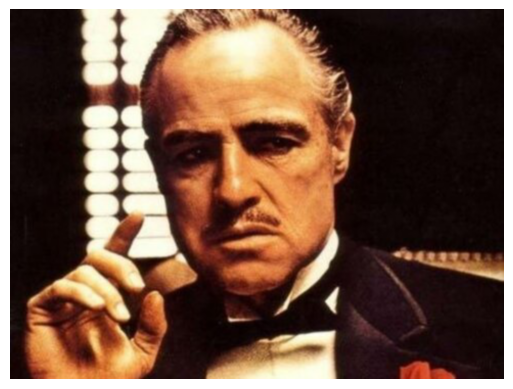

In [4]:
img = cv2.imread('hw_24_img.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, interpolation='bicubic')
plt.axis('off');

In [5]:
#Ищем лица
faces = face_cascade.detectMultiScale(img_rgb, 1.3, 5)
#Мы хотим искать глаза внутри лица
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0),2)
    roi_img = img_rgb[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_img, 1.3, 5)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0,255,0), 2)

In [6]:
x, y, w, h

(117, 55, 208, 208)

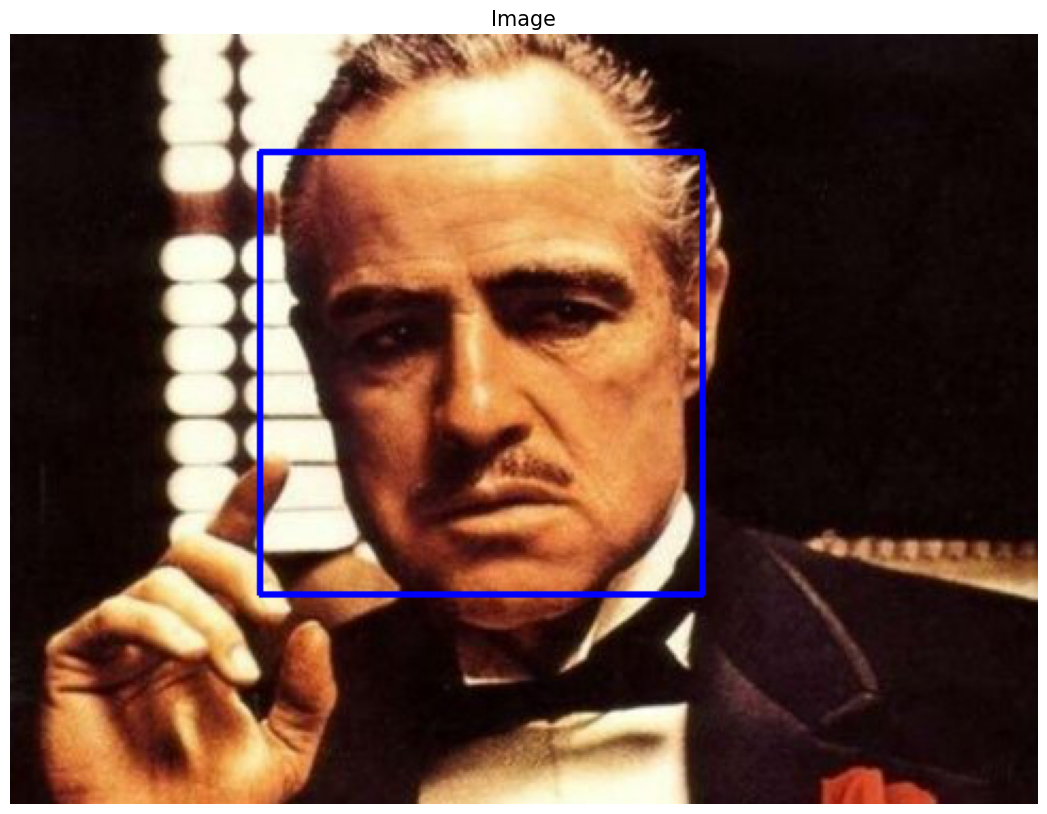

In [7]:
plt.rcParams['figure.figsize'] = 18,10
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image', fontsize=15)
plt.axis('off');

Как видим, лицо получилось определить, а глаза нет. Попробуем на еще одной картинке

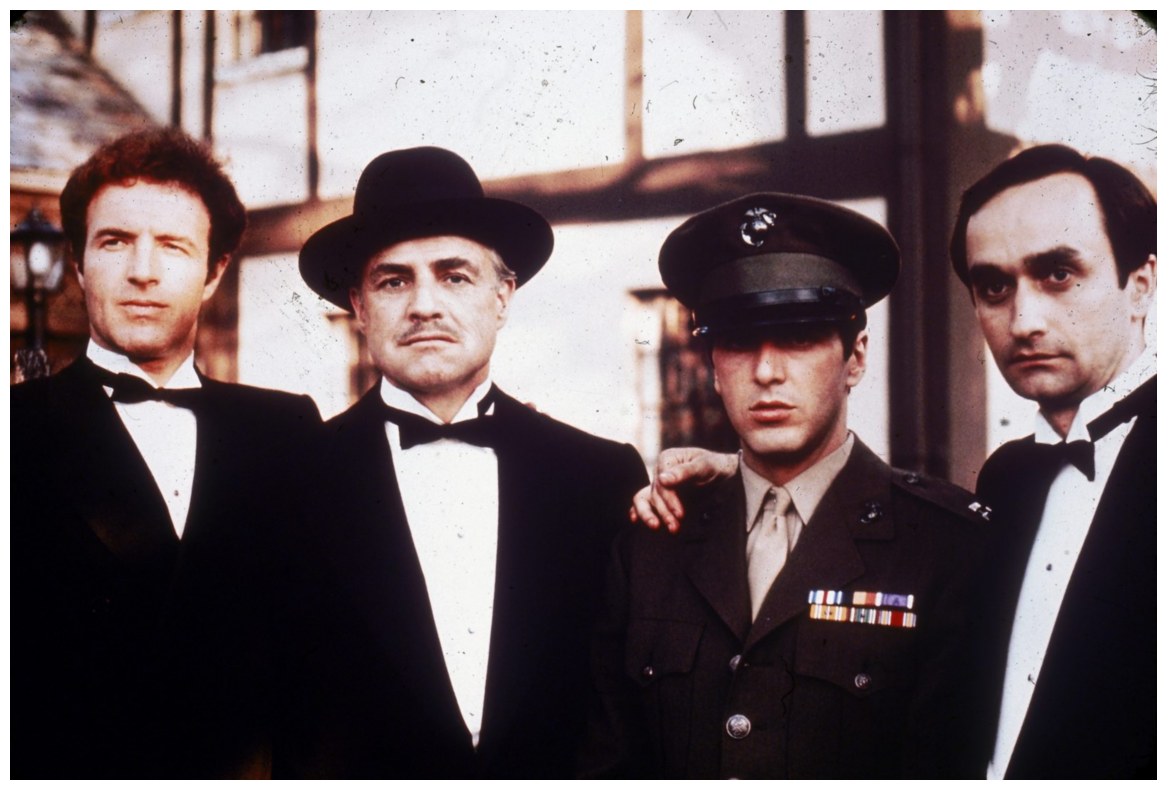

In [8]:
img = cv2.imread('hw_24_img_1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, interpolation='bicubic')
plt.axis('off');

In [9]:
#Ищем лица
faces = face_cascade.detectMultiScale(img_rgb, 1.3, 5)
#Мы хотим искать глаза внутри лица
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0),2)
    roi_img = img_rgb[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_img, 1.3, 5)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0,255,0), 2)

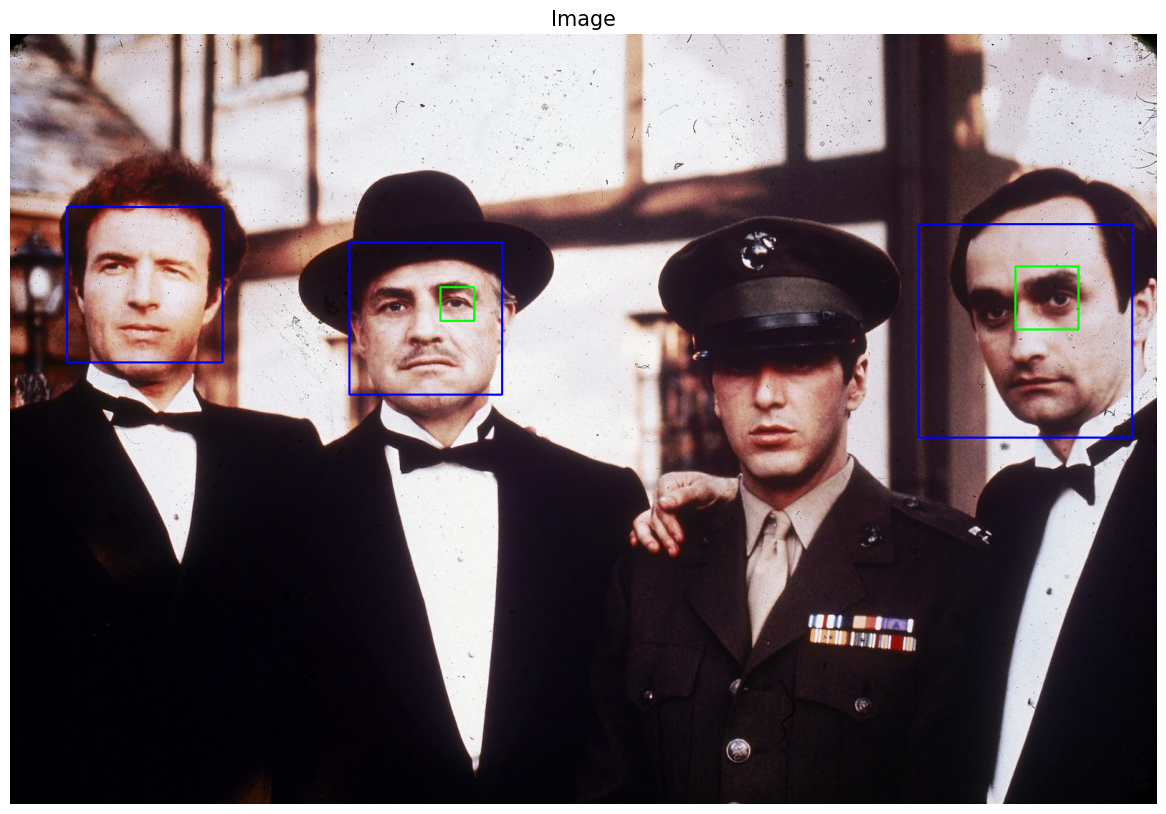

In [10]:
plt.rcParams['figure.figsize'] = 18,10
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image', fontsize=15)
plt.axis('off');

Изначально пыталась нормально установить dlib, но попытка провалилась, поэтому в качестве альтернативы испотзовала библиотеку face_recognition

In [11]:
from imutils import face_utils
import imutils
import dlib

In [12]:
def rect_to_bb(rect):
    #Принимает на вход объект dlib, содержащий координаты лиц и возвращает кортеж
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y


    return (x, y, w, h)

In [13]:
def shape_to_np(shape, dtype="int"):

    # возвращает координаты элементов лица
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    return coords

In [14]:
#detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## Face Recognition 

In [15]:
from imutils import paths
import face_recognition
import pickle
import os

In [16]:
# в директории Images хранятся папки со всеми изображениями
imagePaths = list(paths.list_images(r'C:\Users\User\hw_24\godfather'))
knownEncodings = []
knownNames = []

# перебираем все папки с изображениями
for (i, imagePath) in enumerate(imagePaths):
    # извлекаем имя человека из названия папки
    name = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #используем библиотеку Face_recognition для обнаружения лиц
    boxes = face_recognition.face_locations(rgb,model='hog')
    
    # вычисляем эмбеддинги для каждого лица
    encodings = face_recognition.face_encodings(rgb, boxes)
    # loop over the encodings
    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)
        
# сохраним эмбеддинги вместе с их именами в формате словаря
data = {"encodings": knownEncodings, "names": knownNames}
# для сохранения данных в файл используем метод pickle
f = open(r"C:\Users\User\hw_24\face_enc", "wb")
f.write(pickle.dumps(data))
f.close()

In [17]:
# Считываем данные с файла эмбеддингов
data = pickle.loads(open(r"C:\Users\User\hw_24\face_enc", "rb").read())
# Загружаем картинку на которой будем искать лица
image = cv2.imread('hw_24_img.jpg')
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# преобразуем изображение в серое для каскада
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)


encodings = face_recognition.face_encodings(rgb)
names = []

In [18]:
#проходим по всем найденным лицам на фото и сравниваем их с эмбедингами
for encoding in encodings:
    matches = face_recognition.compare_faces(data["encodings"],
    encoding)
   
    name = "Unknown"

    if True in matches:
        # сохраняем индексы тех лиц, которые были найдены в эмбедингах
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}
        
        for i in matchedIdxs:
            name = data["names"][i]
            counts[name] = counts.get(name, 0) + 1
            name = max(counts, key=counts.get)
        names.append(name)
        for ((x, y, w, h), name) in zip(faces, names):
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, name, (x, y), cv2.FONT_HERSHEY_SIMPLEX,
             0.75, (0, 255, 0), 2)

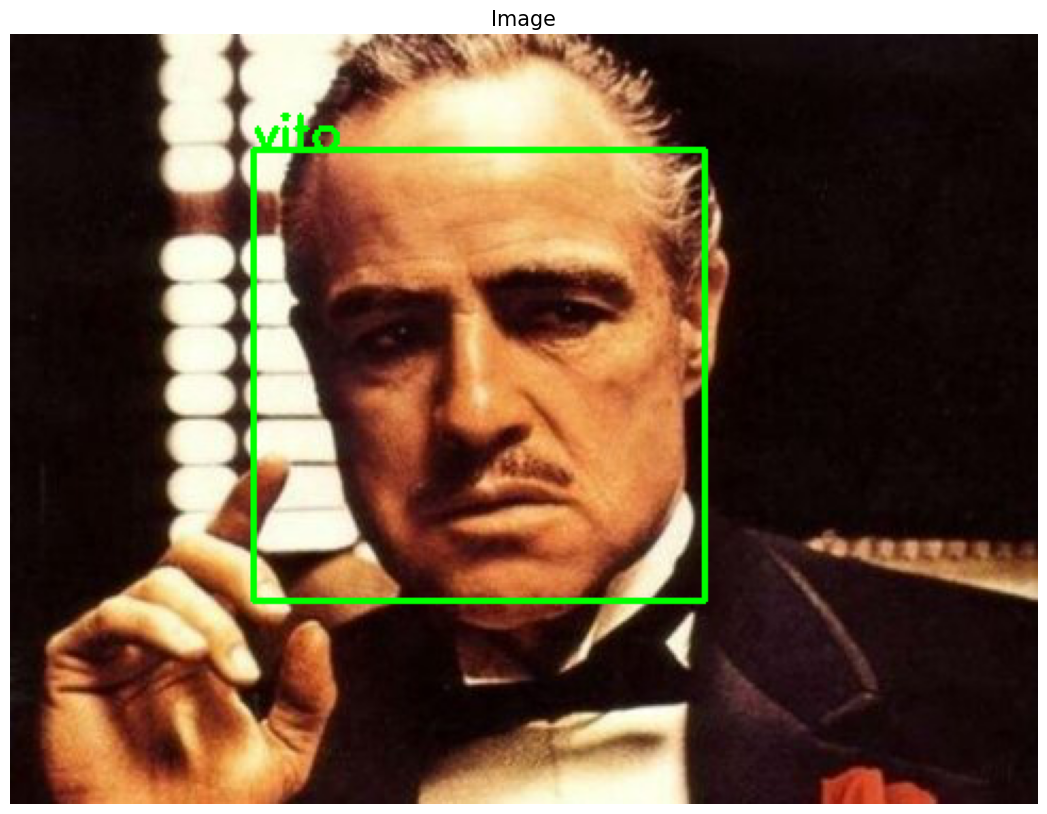

In [19]:
plt.rcParams['figure.figsize'] = 18,10
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image', fontsize=15)
plt.axis('off');

Впрочем отрабатывает это не всегда

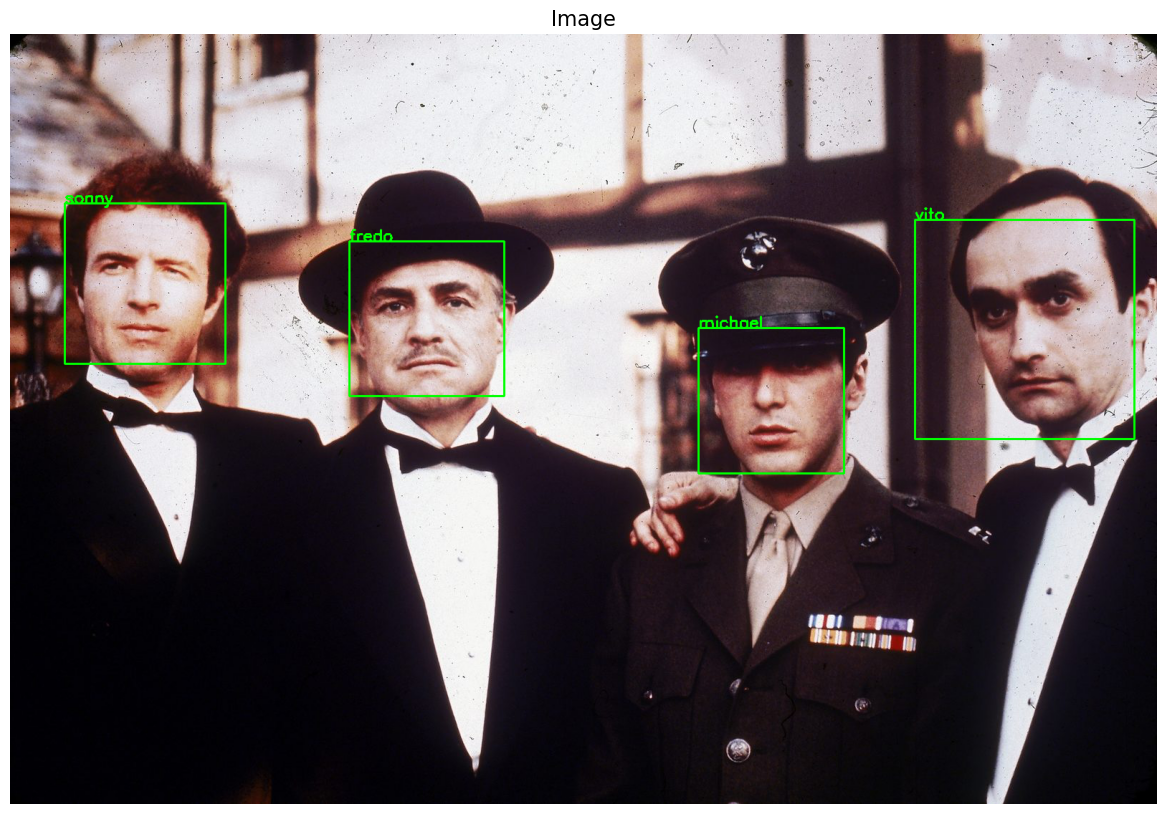

In [21]:
plt.rcParams['figure.figsize'] = 18,10
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image', fontsize=15)
plt.axis('off');

Хотя при этом с использованием библиотеки получилось определить все четыре лица(с использованием только каскадов Хаара удалось определить только три)